# Elevation Handler
The Shuttle Radar Topography Mission (SRTM) conducted by NASA in February 2000 {cite:p}`srtm30` remains a important mission for collecting precise topographic data of the Earth's surface. One of the notable resolutions of the SRTM data is 30 meters, indicating that elevation values are recorded at intervals of 30 meters across the Earth's surface.

Spatially, the data is organized into a grid structure, where each cell represents a spatial unit of 1 degree of latitude by 1 degree of longitude. This 1° x 1° resolution simplifies the representation of geographic locations.

In [1]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

from src.utils import (
    ElevationHandler,
    print_code,
    scale_array_func,
    generate_subarray,
    transform_coordinates,
    resample_to_straight_axis,
    generate_voxel_map,
    download_elevation
)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from matplotlib.ticker import AutoLocator
from IPython.core.display import HTML
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import ipywidgets

ModuleNotFoundError: No module named 'src.utils'

### Import of SRTM data
To utilize the data, a script has been developed. This script automates the download of the pertinent .hgt files and seamlessly integrates them to construct the comprehensive elevation map.

In [2]:
HTML(print_code(download_elevation))

#### Test of function
A simple test is performed to test the script.

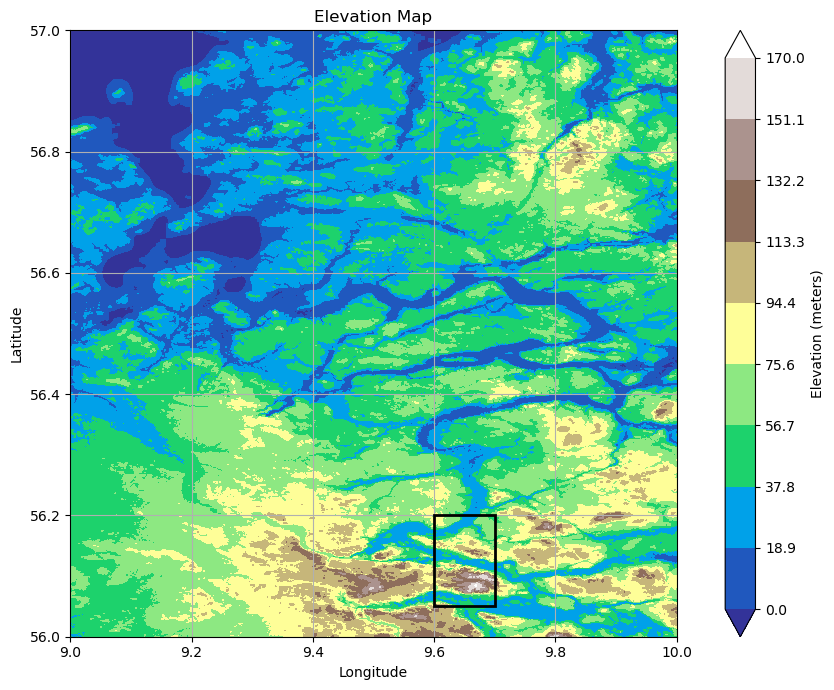

In [3]:
map_boundaries = np.array([9.6, 9.7, 56.05, 56.2])
srtm_longitude, srtm_latitude, merged_map = download_elevation(map_boundaries)

vmin = 0
vmax = float('%.2g' % np.max(merged_map)) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(srtm_longitude, srtm_latitude, merged_map, 
                 levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                 cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# Add the rectangle to the plot
rect = Rectangle(
    xy=(map_boundaries[0], map_boundaries[2]),  # bottom-left corner
    width=(map_boundaries[1] - map_boundaries[0]),  # width
    height=(map_boundaries[3] - map_boundaries[2]),  # height
    linewidth=2,
    edgecolor='k',
    facecolor='none')

ax.add_patch(rect)
rect.set_zorder(3)

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

The depicted plot showcases the complete data range for a singular SRTM file. The small black square displays the subdomain of the map, as defined by the `map_boundaries`. Given the substantial file size of a single SRTM30 dataset, approximately ($3601 \cdot 3601 \approx 1.3\cdot10^7$), and considering that the boundaries frequently exceed those of a typical wind park, there is a need to scale down the dataset and confine the boundaries to the pertinent area. This task is achieved through the utilization of the following function:

In [4]:
HTML(print_code(ElevationHandler.generate_scaled_subarray))

The function uses bivariate spline interpolation to recalculate the elevation for the scaled elevation grid. The results of the function are plotted below.

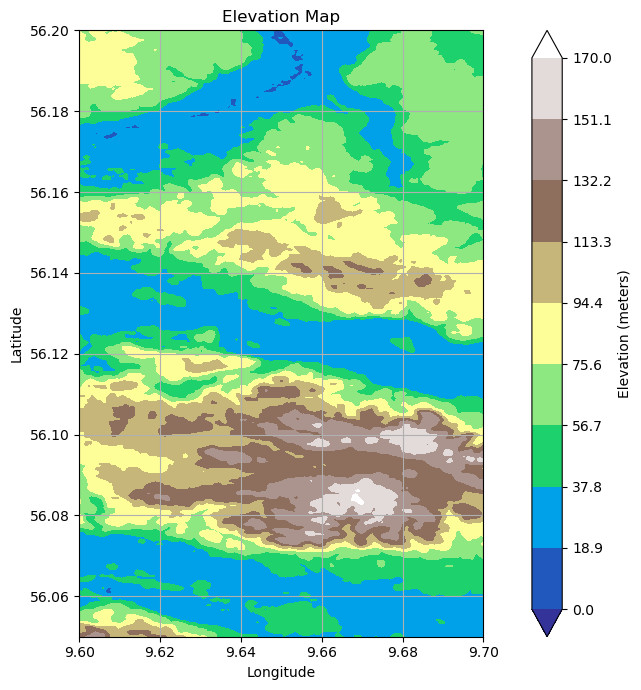

In [5]:
map_shape = [250, 250]
elevation_handler = ElevationHandler(map_boundaries, map_shape)

vmin = np.minimum(0, float('%.2g' % np.max(elevation_handler.map_array)))
vmax = np.maximum(0, float('%.2g' % np.max(elevation_handler.map_array))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(elevation_handler.long_range, elevation_handler.lat_range, elevation_handler.map_array, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## Coordinate Reference Systems
For effective utilization of elevation data in computations for shadow and noise solvers, it is advantageous to transform the Coordinate Reference System (CRS) from EPSG:4326 to EPSG:3035. The advantage of EPSG:3035 lies in the fact that each integer step in the longitude or latitude direction approximately corresponds to a meter (note that EPSG:3035 is specifically accurate for Europe).

In [6]:
HTML(print_code(transform_coordinates))

The map with transformed coordinates can be found below.

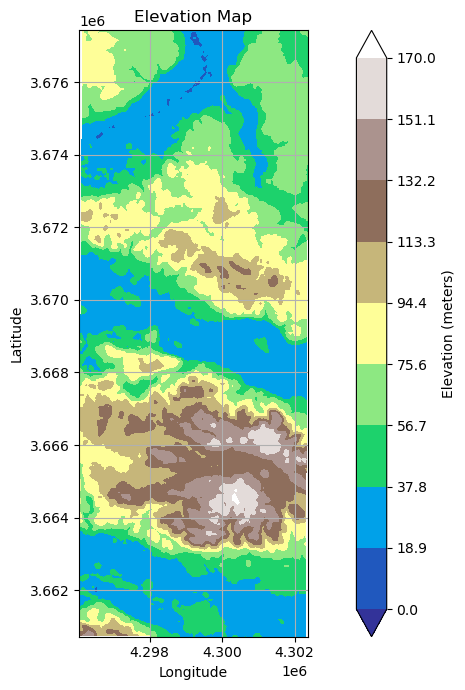

In [7]:
trans_cords = transform_coordinates(elevation_handler.long_range,  elevation_handler.lat_range, input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")

vmin = np.minimum(0, float('%.2g' % np.max(elevation_handler.map_array)))
vmax = np.maximum(0, float('%.2g' % np.max(elevation_handler.map_array))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], elevation_handler.map_array, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

### Rotation of map
Given that the transformation to different Coordinate Reference Systems (CRS) introduces a slight rotation to the map, particularly noticeable on a larger length scale and at higher latitudes, the subsequent function is designed to produce a subarray of the original array with straight axes through cubic interpolation.

In [8]:
HTML(print_code(resample_to_straight_axis))

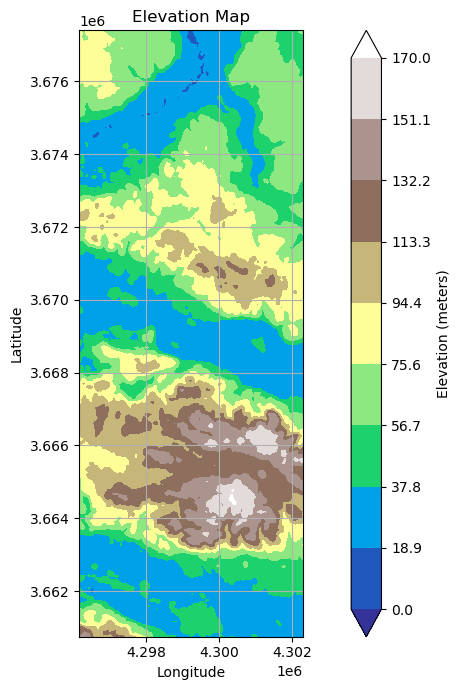

In [9]:
shape = [200, 200]
X, Y, Z = resample_to_straight_axis(trans_cords, elevation_handler.map_array, shape)
vmin = np.minimum(0, float('%.2g' % np.max(Z)))
vmax = np.maximum(0, float('%.2g' % np.max(Z))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(X, Y, Z, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## Google Maps Layer
To enhance result visualization, incorporating satellite imagery underneath the outcomes can provide a valuable reference for the affected areas of shadow flickering and noise disturbance. Google Maps images can be seamlessly integrated, as illustrated below:

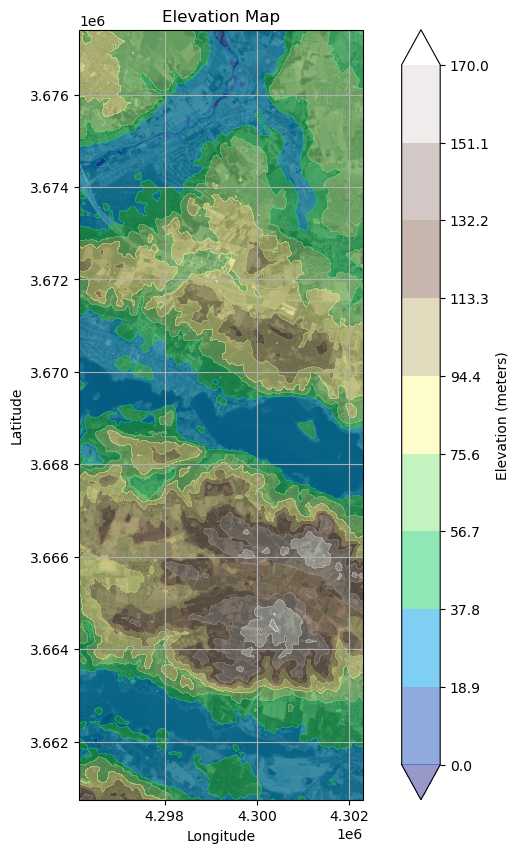

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(3035)}, figsize=(10, 10))
vmin = np.minimum(0, float('%.2g' % np.max(Z)))
vmax = np.maximum(0, float('%.2g' % np.max(Z))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

ct = ax.contourf(X, Y, Z, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain', alpha = 0.5)

plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# ax.set_extent(map_boundaries)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 14) # 16

ax.set_xticks([0], crs=ccrs.epsg(3035))
ax.set_yticks([0], crs=ccrs.epsg(3035))
ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())

plt.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## Convert Elevation to Voxel Map
For the computation of shadow flickering, a ray tracing algorithm is employed to determine the trajectory of sun rays. This algorithm is made for a voxel environment. The terrain undergoes conversion into a voxel map through an iterative process that spans each elevation level—from the lowest to the highest in the map. For each iteration, a boolean slice is generated, where a True boolean signifies elevations below the current iteration, effectively indicating the terrain. Each slice is thereafter stacked on eachother to form the 3D voxel map. The script for the voxel map generator is presented below.

In [11]:
HTML(print_code(generate_voxel_map))

### Test of function
The code is executed by specifying the map boundararies and pixel shape of the map.

In [12]:
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
shape = [200, 200]
X, Y, voxel_map, map_array = generate_voxel_map(map_boundaries, shape)

@ipywidgets.interact(Level=(0, voxel_map.shape[2]-1))
def plot_map(Level):
    colors = ["blue", "brown"]
    cmap = ListedColormap(colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array(voxel_map)
    fig, ax = plt.subplots(figsize = (10, 7))
    ct = ax.pcolormesh(X, Y, voxel_map[:, :, Level],        
                    cmap=cmap, alpha = 0.5)

    plt.colorbar(sm, ax = ax, label='<-- Below (Level) Above -->', ticks = [0, 1])

    ax.grid()
    ax.set_aspect('equal')
    ax.set_title('Elevation Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=78, description='Level', max=157), Output()), _dom_classes=('widget-inte…